In [169]:
import sys
print("Python Version:", sys.version)

import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option('display.max_rows', 500)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Python Version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
# yymmdd format
dates = ['190803',
        '190810',
        '190817',
        '190824',
        '190831',
        '190907',
        '190914',
        '190921',
        '190928']

# iterate through dates and pull in csv and cat dataframes together
df_turns = []
for date in dates:
    df_turns.append(pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_'+date+'.txt'))

In [3]:
# Concat all dataframes
df_turns = pd.concat(df_turns)

In [4]:
#Clean up column names
new_col_names = [name.strip() for name in df_turns.columns]
df_turns.columns = new_col_names

In [5]:
#Let's have a quick look at 'DESC'
df_turns['DESC'].value_counts()

REGULAR       1845436
RECOVR AUD       7577
Name: DESC, dtype: int64

In [6]:
# Audit rows (RECOVR AUD) make up about 0.4% of rows
# Remove audited rows since many are duplicates

df_turns=df_turns[df_turns.DESC!='RECOVR AUD']

# Remove column now that all are regular

del df_turns['DESC']

In [7]:
df_turns.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,00:00:00,7148288,2418935
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,04:00:00,7148306,2418939
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,08:00:00,7148326,2418975
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,12:00:00,7148441,2419042
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,16:00:00,7148647,2419101


In [8]:
# Create a DateTime column that can be used for timeseries
df_turns.loc[:,'DATETIME'] = pd.to_datetime(df_turns['DATE'] + ' ' + df_turns['TIME'])

#Convert Date column to proper date type.
df_turns['DATE']  = pd.to_datetime(df_turns['DATE'],format='%m/%d/%Y')

#convert time to datetime type
df_turns['TIME']=pd.to_datetime(df_turns['TIME'], format='%H:%M:%S')

In [9]:
df_turns.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-07-27,1900-01-01 00:00:00,7148288,2418935,2019-07-27 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-07-27,1900-01-01 04:00:00,7148306,2418939,2019-07-27 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-07-27,1900-01-01 08:00:00,7148326,2418975,2019-07-27 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-07-27,1900-01-01 12:00:00,7148441,2419042,2019-07-27 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-07-27,1900-01-01 16:00:00,7148647,2419101,2019-07-27 16:00:00
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-07-27,1900-01-01 20:00:00,7148908,2419145,2019-07-27 20:00:00
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-07-28,1900-01-01 00:00:00,7149087,2419165,2019-07-28 00:00:00
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-07-28,1900-01-01 04:00:00,7149111,2419171,2019-07-28 04:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-07-28,1900-01-01 08:00:00,7149126,2419198,2019-07-28 08:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-07-28,1900-01-01 12:00:00,7149198,2419241,2019-07-28 12:00:00


In [10]:
#backup
df_backup=df_turns.copy()

In [11]:
#Sort in order of datetime
df_turns = df_turns.sort_values(by=['DATETIME']).reset_index()

In [12]:
# Caluclate Entries Aggregated at station level by DateTime
df_turns['Entry_Diff']=df_turns.groupby(['STATION', 'C/A', 'UNIT', 'SCP'],as_index=False)['ENTRIES'].transform(pd.Series.diff)['ENTRIES']

# Caluclate Exits Aggregated at station level by DateTime
df_turns['Exit_Diff']=df_turns.groupby(['STATION', 'C/A', 'UNIT', 'SCP'],as_index=False)['EXITS'].transform(pd.Series.diff)['EXITS']

In [13]:
#Absolute Value to deal with counting backward issues 
df_turns['Entry_Diff'] = abs(df_turns['Entry_Diff'])
df_turns['Exit_Diff']=abs(df_turns['Exit_Diff'])

# Calculate both
df_turns['Total_Traffic']=df_turns['Entry_Diff']+df_turns['Exit_Diff']

In [14]:
#Drop NaN Values

df_turns.dropna().head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME,Entry_Diff,Exit_Diff,Total_Traffic
2554,118307,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:24:57,65,30,2019-07-27 00:24:57,2.0,0.0,2.0
2592,118308,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:38:57,65,30,2019-07-27 00:38:57,0.0,0.0,0.0
2636,118309,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:52:57,65,30,2019-07-27 00:52:57,0.0,0.0,0.0
2640,118310,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:56:25,4043,3513,2019-07-27 00:56:25,3978.0,3483.0,7461.0
4489,118311,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 01:06:57,65,30,2019-07-27 01:06:57,3978.0,3483.0,7461.0


In [15]:
# Filter out values in calculated fields outside of upper quartile range
#We want to normalize by these values per station


#df_turns.groupby(['STATION'])['Total_Traffic'].quantile(.99)


q_9 = df_turns['Total_Traffic'].quantile(.99)
df_turns_filt = df_turns[df_turns.Total_Traffic<= q_9]

In [16]:
#Let's take a look at the busiest stations after our filter operation:
df_per_station = df_turns_filt.groupby(['STATION']).sum()
df_per_station.sort_values('Total_Traffic', ascending = False).head()

,index,ENTRIES,EXITS,Entry_Diff,Exit_Diff,Total_Traffic
STATION,,,,,,
34 ST-PENN STA,3401972217,1460365699649,1538055094977,8254361.0,6992507.0,15246868.0
GRD CNTRL-42 ST,3752729625,919546458460,1105055715021,5679047.0,4802427.0,10481474.0
23 ST,2607575657,2091252915203,1812031229789,5750528.0,4288698.0,10039226.0
FULTON ST,3245309619,1787737426085,1745103246838,5078558.0,4419547.0,9498105.0
34 ST-HERALD SQ,1402968886,1646402859827,2064647805215,4784950.0,4558398.0,9343348.0


--------

<font size="5">****THIS IS RAMIS PART****

In [17]:
def Add_Weekday(data_frame, column='Date'):
    dmap = {0:'Mon', 1: 'Tue', 2: 'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    #Convert column to date
    data_frame[column] = pd.to_datetime(data_frame[column])
    #Add column which shows the Weekday in integer
    data_frame['Day_Number'] = data_frame[column].apply(lambda x: x.dayofweek)
    #Add column which shows the Weekday in words
    data_frame['Weekday'] = data_frame['Day_Number'].map(dmap)
    return data_frame
df_turns_backup2 = df_turns.copy()

In [18]:
df_turns = Add_Weekday(df_turns,'DATE')
df_turns.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME,Entry_Diff,Exit_Diff,Total_Traffic,Day_Number,Weekday
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-07-27,1900-01-01,7148288,2418935,2019-07-27,NaN,NaN,NaN,5,Sat
1,112391,N605,R024,00-05-01,SUTPHIN-ARCHER,EJZ,IND,2019-07-27,1900-01-01,0,1168,2019-07-27,NaN,NaN,NaN,5,Sat
2,112349,N605,R024,00-05-00,SUTPHIN-ARCHER,EJZ,IND,2019-07-27,1900-01-01,33556743,16777216,2019-07-27,NaN,NaN,NaN,5,Sat
3,198692,R612,R057,01-03-03,ATL AV-BARCLAY,BDNQR2345,IRT,2019-07-27,1900-01-01,2120496,1957954,2019-07-27,NaN,NaN,NaN,5,Sat
4,112307,N605,R024,00-00-06,SUTPHIN-ARCHER,EJZ,IND,2019-07-27,1900-01-01,5050187,2146519,2019-07-27,NaN,NaN,NaN,5,Sat


In [19]:
#Filter out the Null Values
df_turns.dropna(subset=["Entry_Diff","Exit_Diff",'Total_Traffic'], axis=0, inplace=True)
df_turns.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME,Entry_Diff,Exit_Diff,Total_Traffic,Day_Number,Weekday
2554,118307,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:24:57,65,30,2019-07-27 00:24:57,2.0,0.0,2.0,5,Sat
2592,118308,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:38:57,65,30,2019-07-27 00:38:57,0.0,0.0,0.0,5,Sat
2636,118309,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:52:57,65,30,2019-07-27 00:52:57,0.0,0.0,0.0,5,Sat
2640,118310,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:56:25,4043,3513,2019-07-27 00:56:25,3978.0,3483.0,7461.0,5,Sat
4489,118311,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 01:06:57,65,30,2019-07-27 01:06:57,3978.0,3483.0,7461.0,5,Sat


In [20]:
dfc_grouped = df_turns.groupby(['DATE', 'STATION', 'Weekday'])['Entry_Diff', 'Exit_Diff', 'Total_Traffic'].sum().reset_index()
dfc_grouped.head()

/Users/lewissears/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,DATE,STATION,Weekday,Entry_Diff,Exit_Diff,Total_Traffic
0,2019-07-27,1 AV,Sat,4308.0,5146.0,9454.0
1,2019-07-27,103 ST,Sat,8648.0,8190.0,16838.0
2,2019-07-27,103 ST-CORONA,Sat,11712.0,6833.0,18545.0
3,2019-07-27,104 ST,Sat,2040.0,862.0,2902.0
4,2019-07-27,110 ST,Sat,5529.0,5140.0,10669.0


In [21]:
#The upper_quant_df outputs a dataframe of the upper 95% values for each station
upper_quant_df = dfc_grouped.groupby(['STATION'])['Total_Traffic'].quantile([.95]).reset_index()
#Then I merge it with the grouped data 

df_turns_no_outlier = dfc_grouped.merge(upper_quant_df, on='STATION')
df_turns_no_outlier.head()

,DATE,STATION,Weekday,Entry_Diff,Exit_Diff,Total_Traffic_x,level_1,Total_Traffic_y
0,2019-07-27,1 AV,Sat,4308.0,5146.0,9454.0,0.95,40228.0
1,2019-07-28,1 AV,Sun,4106.0,5309.0,9415.0,0.95,40228.0
2,2019-07-29,1 AV,Mon,14483.0,16525.0,31008.0,0.95,40228.0
3,2019-07-30,1 AV,Tue,16375.0,18206.0,34581.0,0.95,40228.0
4,2019-07-31,1 AV,Wed,16812.0,19777.0,36589.0,0.95,40228.0


In [22]:
#delete the rows where The difference between Total_Traffic_y and Total_Traffic_x < 0
df_turns_no_outlier['Diff'] = df_turns_no_outlier['Total_Traffic_y'] - df_turns_no_outlier['Total_Traffic_x']
df_turns_no_outlier = df_turns_no_outlier[df_turns_no_outlier['Diff']>= 0]
df_turns_no_outlier = df_turns_no_outlier.sort_values('Weekday')
df_turns_no_outlier[df_turns_no_outlier['STATION']=='FULTON ST']

,DATE,STATION,Weekday,Entry_Diff,Exit_Diff,Total_Traffic_x,level_1,Total_Traffic_y,Diff
14181,2019-08-09,FULTON ST,Fri,94776.0,80917.0,175693.0,0.95,507437.0,331744.0
14174,2019-08-02,FULTON ST,Fri,95880.0,84251.0,180131.0,0.95,507437.0,327306.0
14188,2019-08-16,FULTON ST,Fri,82130.0,61028.0,143158.0,0.95,507437.0,364279.0
14195,2019-08-23,FULTON ST,Fri,88209.0,78941.0,167150.0,0.95,507437.0,340287.0
14202,2019-08-30,FULTON ST,Fri,85186.0,74439.0,159625.0,0.95,507437.0,347812.0
14209,2019-09-06,FULTON ST,Fri,143818.0,218053.0,361871.0,0.95,507437.0,145566.0
14230,2019-09-27,FULTON ST,Fri,101800.0,90237.0,192037.0,0.95,507437.0,315400.0
14223,2019-09-20,FULTON ST,Fri,108503.0,93163.0,201666.0,0.95,507437.0,305771.0
14216,2019-09-13,FULTON ST,Fri,103527.0,90791.0,194318.0,0.95,507437.0,313119.0
14184,2019-08-12,FULTON ST,Mon,91841.0,81610.0,173451.0,0.95,507437.0,333986.0


-------------

**Only Analysis on Street Canvassing:** "It's Better to look for a neightborhood during lunch and evening hours. A heavy concentration of restaurants and bars where people are wandering and waiting for a table is usually a good bet."

<font size="5">**Weekdays**

In [151]:
df_max_no_outlier = df_turns_no_outlier.groupby(['STATION']).sum()

In [152]:
#Make a DataFrame that is simply Station/Weekday/Traffic
df_reduce = df_turns_no_outlier[['DATE','STATION','Weekday','Total_Traffic_x']].copy()
df_reduce['TRAFFIC'] = df_reduce['Total_Traffic_x']
df_reduce = df_reduce.drop(['Total_Traffic_x'], axis = 1)
df_reduce_grouped = df_reduce.groupby(['STATION', 'Weekday'])['TRAFFIC'].mean().reset_index()
df_reduce_grouped.head(10)

,STATION,Weekday,TRAFFIC
0,1 AV,Fri,35681.833333
1,1 AV,Mon,29466.000000
2,1 AV,Sat,13435.111111
3,1 AV,Sun,9933.666667
4,1 AV,Thu,36339.875000
5,1 AV,Tue,34532.777778
6,1 AV,Wed,36531.000000
7,103 ST,Fri,49484.333333
8,103 ST,Mon,44940.222222
9,103 ST,Sat,29862.000000


In [153]:
#Create Week and Weekend Buckets

def daytype(day):
    if day == 'Sat' or day == 'Sun':
        return 'Weekend'
    else:
        return 'Weekday'

df_reduce_grouped['Day_Type'] = df_reduce_grouped['Weekday'].apply(daytype)
df_reduce_grouped

,STATION,Weekday,TRAFFIC,Day_Type
0,1 AV,Fri,35681.833333,Weekday
1,1 AV,Mon,29466.000000,Weekday
2,1 AV,Sat,13435.111111,Weekend
3,1 AV,Sun,9933.666667,Weekend
4,1 AV,Thu,36339.875000,Weekday
...,...,...,...,...
2641,ZEREGA AV,Sat,2390.777778,Weekend
2642,ZEREGA AV,Sun,1887.444444,Weekend
2643,ZEREGA AV,Thu,5228.111111,Weekday
2644,ZEREGA AV,Tue,5015.714286,Weekday


In [154]:
df_reduce_grouped_day_type = df_reduce_grouped.groupby(['STATION','Day_Type'])['TRAFFIC'].mean().reset_index()
df_reduce_grouped_day_type.head(20)

,STATION,Day_Type,TRAFFIC
0,1 AV,Weekday,34510.297222
1,1 AV,Weekend,11684.388889
2,103 ST,Weekday,48761.161905
3,103 ST,Weekend,27598.333333
4,103 ST-CORONA,Weekday,34081.658333
5,103 ST-CORONA,Weekend,23233.500000
6,104 ST,Weekday,6013.859524
7,104 ST,Weekend,2266.111111
8,110 ST,Weekday,18904.488889
9,110 ST,Weekend,12210.166667


------------

<font size="5">**By Time of Day**

In [155]:
def convertTimeBuckets(time):
    
    """
    This function creates a new column that groups time intervals into categories:
    
    00:00 < late night <= 4:00
    4:00 < early risers <= 8:00
    8:00 < morning <= 12:00
    12:00 < afternoon <= 16:00
    16:00 < evening  <= 20:00
    20:00 < late night <= 00:00
    """
    
    hour = time.hour
    if hour > 20 or hour == 0:
        category = 'Late Night'
    elif hour > 16:
        category = 'Evening'
    elif hour > 12:
        category = 'Afternoon'
    elif hour > 8:
        category = 'Morning'
    elif hour > 4:
        category = 'Early Morning'
    elif hour > 0:
        category = 'Late Night'
    
    return category

In [156]:
df_turns['Day_Bucket'] = df_turns['TIME'].apply(convertTimeBuckets)
df_turns['Day_Type'] = df_turns['Weekday'].apply(daytype)
df_turns['Day_Bucket'] = pd.Categorical(df_turns['Day_Bucket'], categories=
    ['Early Morning','Morning','Afternoon','Evening','Late Night'],
    ordered=True)

In [157]:
df_buckets_grouped = df_turns.groupby(['STATION','Day_Bucket','Day_Type'])['Total_Traffic'].mean().reset_index()
df_buckets_grouped['Plot_Index']=df_buckets_grouped['Day_Bucket'].apply(indexfun)
df_buckets_grouped['Day_Bucket'] = pd.Categorical(df_buckets_grouped['Day_Bucket'], categories=
    ['Early Morning','Morning','Afternoon','Evening','Late Night'],
    ordered=True)
df_buckets_grouped.head(10)

,STATION,Day_Bucket,Day_Type,Total_Traffic,Plot_Index
0,1 AV,Early Morning,Weekday,376.502128,1
1,1 AV,Early Morning,Weekend,49.766667,1
2,1 AV,Morning,Weekday,855.386667,2
3,1 AV,Morning,Weekend,144.711111,2
4,1 AV,Afternoon,Weekday,729.444444,3
5,1 AV,Afternoon,Weekend,268.783333,3
6,1 AV,Evening,Weekday,1122.357778,4
7,1 AV,Evening,Weekend,222.833333,4
8,1 AV,Late Night,Weekday,197.621111,0
9,1 AV,Late Night,Weekend,209.862857,0


In [158]:
daytime = ['Late Night','Early Morning', 'Morning', 'Afternoon','Evening']
def indexfun(bucket):
    if bucket == 'Late Night':
        return 0
    if bucket == 'Early Morning':
        return 1
    if bucket == 'Morning':
        return 2
    if bucket == 'Afternoon':
        return 3
    if bucket == 'Evening':
        return 4
df_buckets_grouped['Plot_Index']=df_buckets_grouped['Day_Bucket'].apply(indexfun)

#Anthony's category shift

df_buckets_grouped['Day_Bucket'] = pd.Categorical(df_buckets_grouped['Day_Bucket'], categories=
    ['Early Morning','Morning','Afternoon','Evening','Late Night'],
    ordered=True)
df_buckets_grouped.head(10)

,STATION,Day_Bucket,Day_Type,Total_Traffic,Plot_Index
0,1 AV,Early Morning,Weekday,376.502128,1
1,1 AV,Early Morning,Weekend,49.766667,1
2,1 AV,Morning,Weekday,855.386667,2
3,1 AV,Morning,Weekend,144.711111,2
4,1 AV,Afternoon,Weekday,729.444444,3
5,1 AV,Afternoon,Weekend,268.783333,3
6,1 AV,Evening,Weekday,1122.357778,4
7,1 AV,Evening,Weekend,222.833333,4
8,1 AV,Late Night,Weekday,197.621111,0
9,1 AV,Late Night,Weekend,209.862857,0


In [159]:
df_buckets_weekday = df_buckets_grouped[df_buckets_grouped['Day_Type'] == 'Weekday']
df_buckets_weekend = df_buckets_grouped[df_buckets_grouped['Day_Type'] == 'Weekend']

In [160]:
# Grand Central 42nd street is a problem

df_buckets_weekday[df_buckets_weekday['STATION'] == 'GRD CNTRL-42 ST']

,STATION,Day_Bucket,Day_Type,Total_Traffic,Plot_Index
2320,GRD CNTRL-42 ST,Early Morning,Weekday,232.333333,1
2322,GRD CNTRL-42 ST,Morning,Weekday,3152.470686,2
2324,GRD CNTRL-42 ST,Afternoon,Weekday,425826.634514,3
2326,GRD CNTRL-42 ST,Evening,Weekday,1625.233277,4
2328,GRD CNTRL-42 ST,Late Night,Weekday,2766.791597,0


In [161]:
df_buckets_weekday['Day_Bucket'] = pd.Categorical(df_buckets_weekday['Day_Bucket'], categories=
    ['Early Morning','Morning','Afternoon','Evening','Late Night'],
    ordered=True)
df_buckets_weekday

/Users/lewissears/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,STATION,Day_Bucket,Day_Type,Total_Traffic,Plot_Index
0,1 AV,Early Morning,Weekday,376.502128,1
2,1 AV,Morning,Weekday,855.386667,2
4,1 AV,Afternoon,Weekday,729.444444,3
6,1 AV,Evening,Weekday,1122.357778,4
8,1 AV,Late Night,Weekday,197.621111,0
...,...,...,...,...,...
3770,ZEREGA AV,Early Morning,Weekday,22.900000,1
3772,ZEREGA AV,Morning,Weekday,255.777778,2
3774,ZEREGA AV,Afternoon,Weekday,138.692593,3
3776,ZEREGA AV,Evening,Weekday,190.596296,4


In [162]:
sums = df_buckets_grouped.groupby(['STATION']).sum()
top_30 = sums['Total_Traffic'].nlargest(30)
top_30

STATION
CYPRESS AV         2.641197e+07
HUNTS POINT AV     7.026393e+06
LAFAYETTE AV       5.059442e+06
3 AV-149 ST        3.520996e+06
72 ST              3.491998e+06
5 AVE              3.418172e+06
161/YANKEE STAD    1.566737e+06
14 ST              1.561882e+06
59 ST              1.180548e+06
51 ST              1.125224e+06
BAY PKWY           9.475492e+05
GRD CNTRL-42 ST    4.358490e+05
18 ST              2.991713e+05
ROCKAWAY BLVD      2.911962e+05
NECK RD            2.707720e+05
SOUTH FERRY        2.397750e+05
LIVONIA AV         1.523451e+05
191 ST             1.272162e+05
BOROUGH HALL       1.269776e+05
NEW LOTS           1.244737e+05
157 ST             8.484784e+04
49 ST              7.795557e+04
PARSONS BLVD       6.222548e+04
JEFFERSON ST       5.798689e+04
FORDHAM RD         4.950591e+04
BAY RIDGE AV       3.012301e+04
WEST FARMS SQ      2.931465e+04
HOUSTON ST         2.695057e+04
FULTON ST          2.579110e+04
ROCKAWAY AV        2.385432e+04
Name: Total_Traffic, dtype: floa

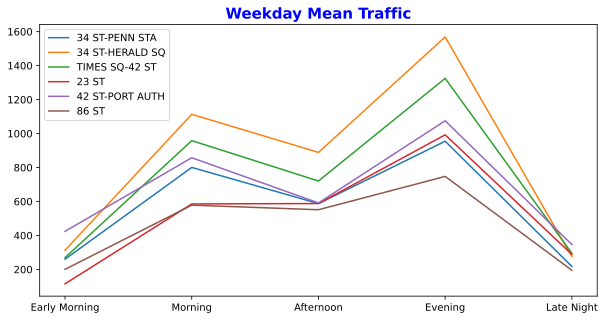

In [177]:
#Busy Stations during Weekdays

plt.figure(figsize=(10,5))
for station in ['34 ST-PENN STA', '34 ST-HERALD SQ', 'TIMES SQ-42 ST', '23 ST', '42 ST-PORT AUTH', '86 ST']:
    plt.plot(df_buckets_weekday[df_buckets_weekday['STATION'] == station]['Day_Bucket'],df_buckets_weekday[df_buckets_weekday['STATION'] == station]['Total_Traffic'])

plt.title('Weekday Mean Traffic',fontsize = 15,weight='bold',color='Blue')
plt.legend(['34 ST-PENN STA', '34 ST-HERALD SQ', 'TIMES SQ-42 ST', '23 ST', '42 ST-PORT AUTH', '86 ST']);
plt.savefig('Weekday_Traffic.png')

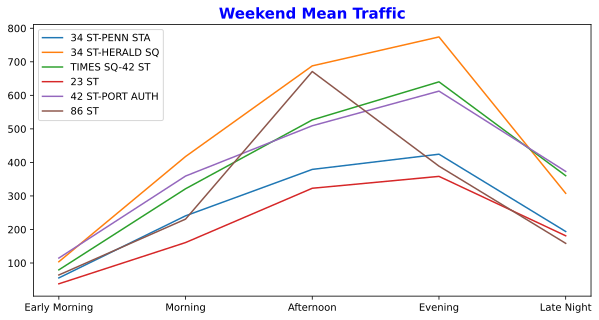

In [178]:
#Busy Stations During Weekends

plt.figure(figsize=(10,5))
for station in ['34 ST-PENN STA', '34 ST-HERALD SQ', 'TIMES SQ-42 ST', '23 ST', '42 ST-PORT AUTH', '86 ST']:
    plt.plot(df_buckets_weekend[df_buckets_weekend['STATION'] == station]['Day_Bucket'],df_buckets_weekend[df_buckets_weekend['STATION'] == station]['Total_Traffic'])

plt.title('Weekend Mean Traffic',fontsize = 15,weight='bold',color='Blue')
plt.legend(['34 ST-PENN STA', '34 ST-HERALD SQ', 'TIMES SQ-42 ST', '23 ST', '42 ST-PORT AUTH', '86 ST']);
plt.savefig('Weekend_Traffic.png')

In [165]:
df_buckets_weekday[df_buckets_weekday['Day_Bucket'] == 'Afternoon'].sort_values('Total_Traffic', ascending = False)

,STATION,Day_Bucket,Day_Type,Total_Traffic,Plot_Index
2684,LAFAYETTE AV,Afternoon,Weekday,5.058636e+06,3
554,3 AV-149 ST,Afternoon,Weekday,3.518721e+06,3
774,5 AVE,Afternoon,Weekday,3.415378e+06,3
134,14 ST,Afternoon,Weekday,1.559127e+06,3
1364,BAY PKWY,Afternoon,Weekday,9.458698e+05,3
2324,GRD CNTRL-42 ST,Afternoon,Weekday,4.258266e+05,3
324,18 ST,Afternoon,Weekday,2.974164e+05,3
3314,ROCKAWAY BLVD,Afternoon,Weekday,2.899026e+05,3
3404,SOUTH FERRY,Afternoon,Weekday,2.383079e+05,3
2944,NEW LOTS,Afternoon,Weekday,1.213651e+05,3


In [166]:
df_buckets_weekend

,STATION,Day_Bucket,Day_Type,Total_Traffic,Plot_Index
1,1 AV,Early Morning,Weekend,49.766667,1
3,1 AV,Morning,Weekend,144.711111,2
5,1 AV,Afternoon,Weekend,268.783333,3
7,1 AV,Evening,Weekend,222.833333,4
9,1 AV,Late Night,Weekend,209.862857,0
...,...,...,...,...,...
3771,ZEREGA AV,Early Morning,Weekend,18.259259,1
3773,ZEREGA AV,Morning,Weekend,53.240741,2
3775,ZEREGA AV,Afternoon,Weekend,70.970588,3
3777,ZEREGA AV,Evening,Weekend,93.740741,4


In [1]:
df_buckets_weekend

NameError: name 'df_buckets_weekend' is not defined